<a href="https://colab.research.google.com/github/KT2001/GemstoneClassification/blob/main/GemstoneClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1.Importing the dependencies.**




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets  # contains datasets, model architectures and image transformations often used for computer vision problems.
from torch.autograd import Variable
from torch.optim import Adam, LBFGS, lr_scheduler
from torchvision.utils import save_image
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from glob import glob
import pathlib

In [2]:
torch.__version__

'1.12.1+cu113'

In [3]:
torch.cuda.is_available()

True

In [4]:
# Creating device augnastic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!nvidia-smi

Wed Sep 28 11:24:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |    788MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **2.Downloading the dataset and transforming it.**

In [6]:
!pip install -q kaggle  # to work with kaggle dataset 

In [7]:
from google.colab import files #ADD Kaggle.jason
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
!pwd

/content


making a kaggle directory

In [9]:
!mkdir ~/.kaggle

In [10]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [11]:
!chmod 600 /root/.kaggle/kaggle.json

In [12]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          11446        338  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           3517         91  1.0              
harshsingh2209/tesla-stock-pricing-20172022                    TESLA stock pricing (2017-2022)                      28KB  2022-09-18 14:56:29            679         27  1.0              
thedevastator/airplane-crashes-and-fatalities                  Ai

The dataset we are using is [Gemstones Images](https://www.kaggle.com/datasets/lsind18/gemstones-images)


## **About Dataset**


# Content

This dataset contains 3,200+ images of different gemstones. The images are grouped into 87 classes which are already divided into train and test data. All images are in various sizes and are in .jpeg format.
As for gemstones I tried to include them in various shapes - round, oval, square, rectangle, heart.

**This dataset is composed of two folders**:

train (~56 MB): This file contains 87 subfolders and ~2,800 files in total. Each subfolder contains .jpeg images of different gemstones.

test (~8 MB): This file contains 87 subfolders and ~400 files in total. Each subfolder contains .jpeg images of different gemstones.

# Acknowledgements

Most pictures were parsed from minerals.net and www.rasavgems.com websites. The images are taken from kaggle.

In [13]:
!kaggle datasets download -d lsind18/gemstones-images  # downloading the datset

 92% 51.0M/55.2M [00:00<00:00, 122MB/s]
100% 55.2M/55.2M [00:00<00:00, 130MB/s]


In [14]:
!unzip gemstones-images.zip  # unzipping the files

Archive:  gemstones-images.zip
  inflating: test/Alexandrite/alexandrite_18.jpg  
  inflating: test/Alexandrite/alexandrite_28.jpg  
  inflating: test/Alexandrite/alexandrite_3.jpg  
  inflating: test/Alexandrite/alexandrite_6.jpg  
  inflating: test/Almandine/almandine_18.jpg  
  inflating: test/Almandine/almandine_28.jpg  
  inflating: test/Almandine/almandine_3.jpg  
  inflating: test/Almandine/almandine_9.jpg  
  inflating: test/Amazonite/amazonite_18.jpg  
  inflating: test/Amazonite/amazonite_28.jpg  
  inflating: test/Amazonite/amazonite_3.jpg  
  inflating: test/Amazonite/amazonite_8.jpg  
  inflating: test/Amber/amber_18.jpg  
  inflating: test/Amber/amber_28.jpg  
  inflating: test/Amber/amber_3.jpg  
  inflating: test/Amber/amber_9.jpg  
  inflating: test/Amethyst/amethyst_18.jpg  
  inflating: test/Amethyst/amethyst_3.jpg  
  inflating: test/Amethyst/amethyst_5.jpg  
  inflating: test/Amethyst/amethyst_7.jpg  
  inflating: test/Ametrine/ametrine_18.jpg  
  inflating: test/A

In [15]:
import pathlib
train_dir = pathlib.Path("/content/train")
test_dir = pathlib.Path("/content/test")

In [16]:
train_dir

PosixPath('/content/train')

[PosixPath('/content/train/Aventurine Yellow/aventurine yellow_12.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_23.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_0.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_36.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_9.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_2.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_24.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_4.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_1.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_26.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_35.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_34.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_10.jpg'), PosixPath('/content/train/Aventurine Yellow/aventurine yellow_21.jpg

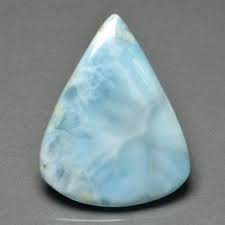

In [17]:
import random
from PIL import Image

# Set seed
random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list = list(train_dir.glob("*/*.jpg"))

print(image_path_list)

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [18]:
# Write transform for image
train_data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    # Turn the image into a torch.Tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

# Write transform for image
test_data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

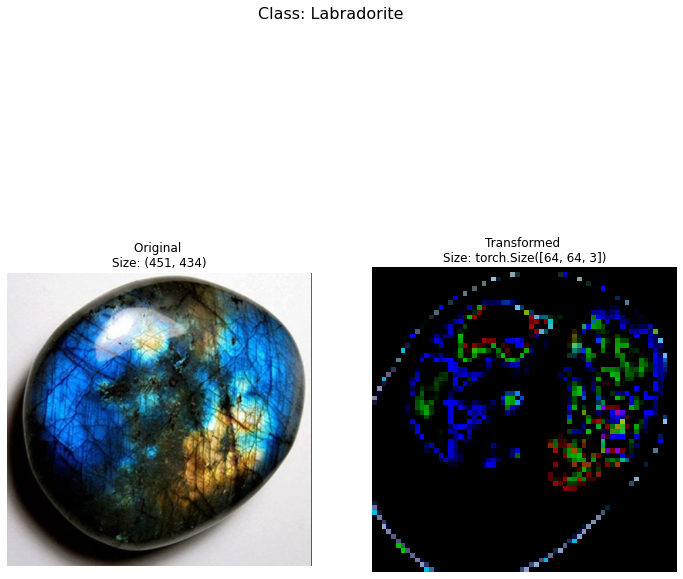

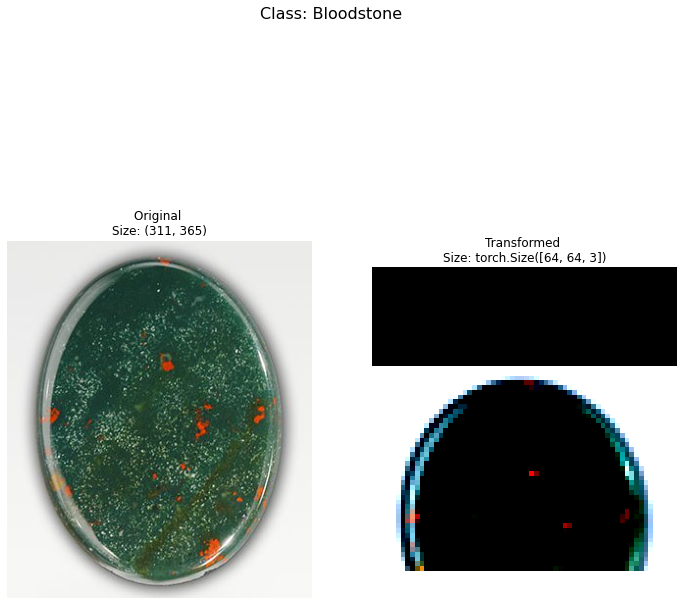

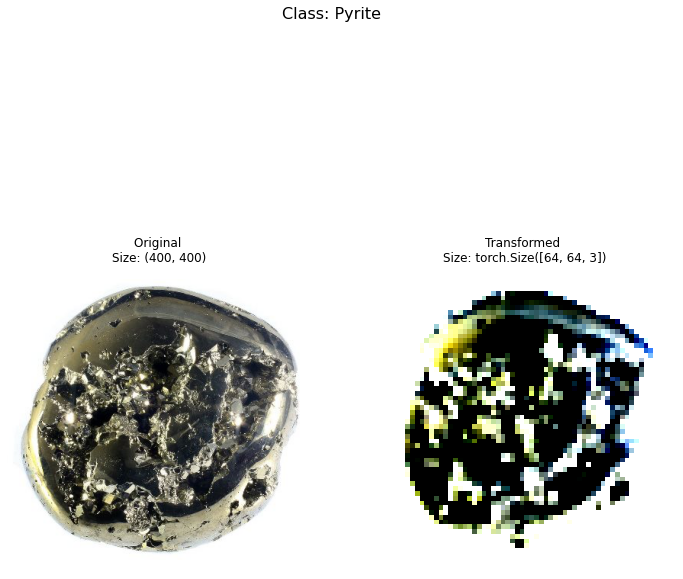

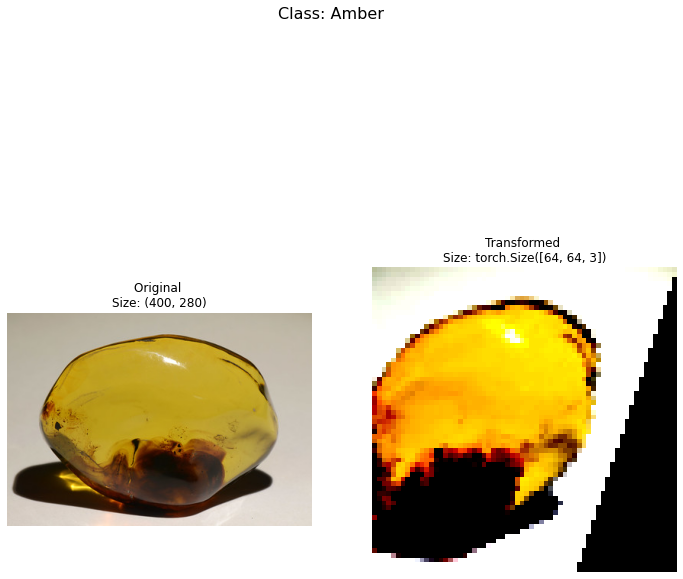

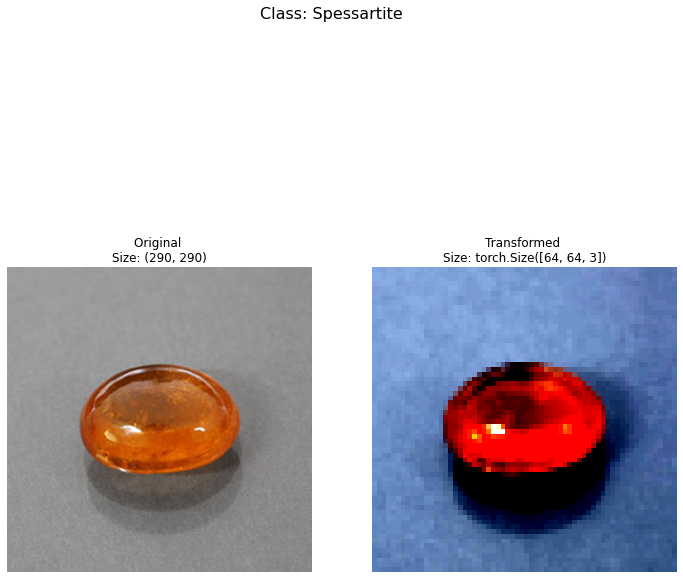

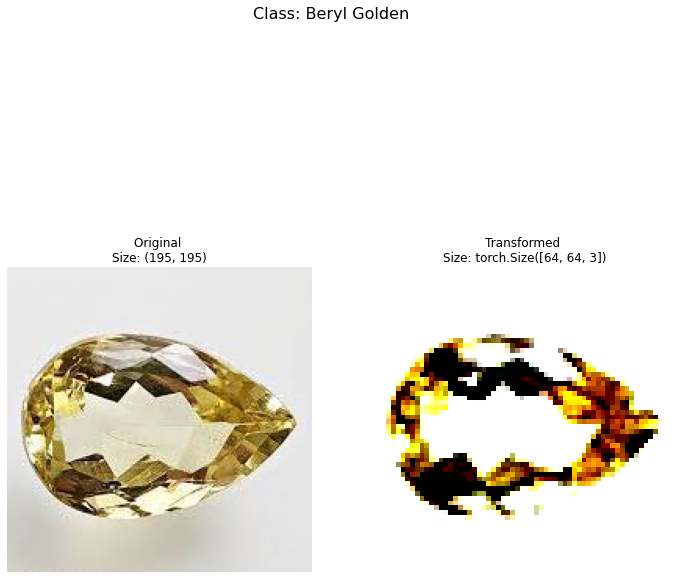

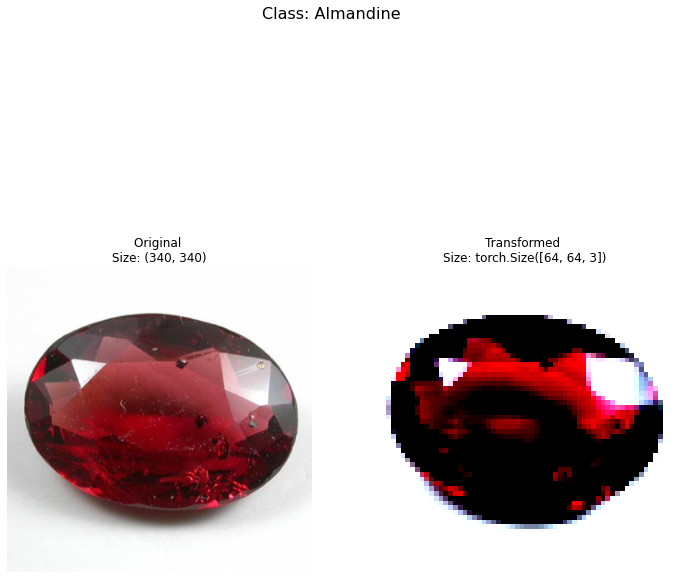

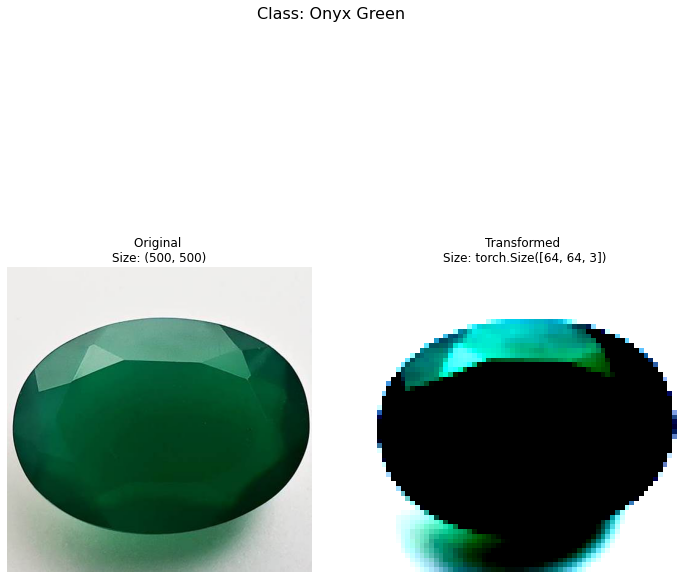

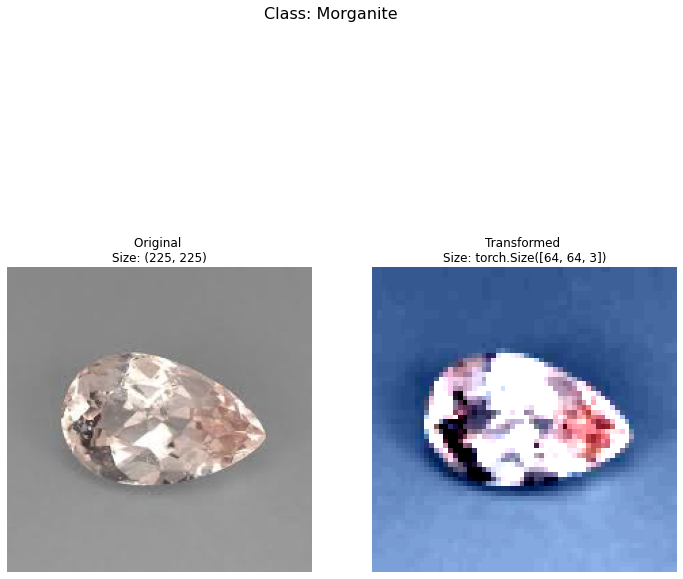

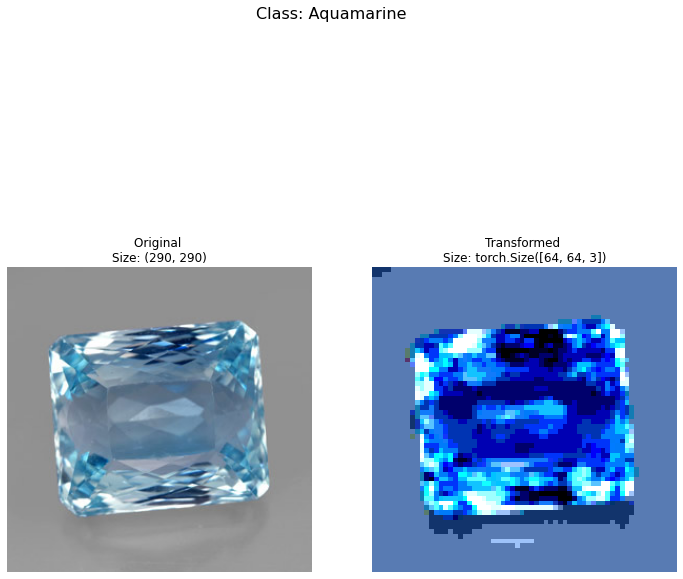

In [19]:
# creating a helper function
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=train_data_transform, 
                        n=10)

In [20]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2856
    Root location: /content/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 363
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [21]:
# Get class names as a list
class_names = train_data.classes
class_names

['Alexandrite',
 'Almandine',
 'Amazonite',
 'Amber',
 'Amethyst',
 'Ametrine',
 'Andalusite',
 'Andradite',
 'Aquamarine',
 'Aventurine Green',
 'Aventurine Yellow',
 'Benitoite',
 'Beryl Golden',
 'Bixbite',
 'Bloodstone',
 'Blue Lace Agate',
 'Carnelian',
 'Cats Eye',
 'Chalcedony',
 'Chalcedony Blue',
 'Chrome Diopside',
 'Chrysoberyl',
 'Chrysocolla',
 'Chrysoprase',
 'Citrine',
 'Coral',
 'Danburite',
 'Diamond',
 'Diaspore',
 'Dumortierite',
 'Emerald',
 'Fluorite',
 'Garnet Red',
 'Goshenite',
 'Grossular',
 'Hessonite',
 'Hiddenite',
 'Iolite',
 'Jade',
 'Jasper',
 'Kunzite',
 'Kyanite',
 'Labradorite',
 'Lapis Lazuli',
 'Larimar',
 'Malachite',
 'Moonstone',
 'Morganite',
 'Onyx Black',
 'Onyx Green',
 'Onyx Red',
 'Opal',
 'Pearl',
 'Peridot',
 'Prehnite',
 'Pyrite',
 'Pyrope',
 'Quartz Beer',
 'Quartz Lemon',
 'Quartz Rose',
 'Quartz Rutilated',
 'Quartz Smoky',
 'Rhodochrosite',
 'Rhodolite',
 'Rhodonite',
 'Ruby',
 'Sapphire Blue',
 'Sapphire Pink',
 'Sapphire Purple',
 '

In [24]:
len(class_names)  # we have 87 classes

87

In [22]:
# we will check what is the length of train data and test data
print(f"Length of train data {len(train_data)}, length of test data {len(test_data)}")

Length of train data 2856, length of test data 363


In [23]:
torch.manual_seed(42)
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.64

Our images are now in the form of a tensor (with shape [3, 64, 64]) and the labels are in the form of an integer relating to a specific class (as referenced by the class_to_idx attribute).

How about we plot a single image tensor using matplotlib?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


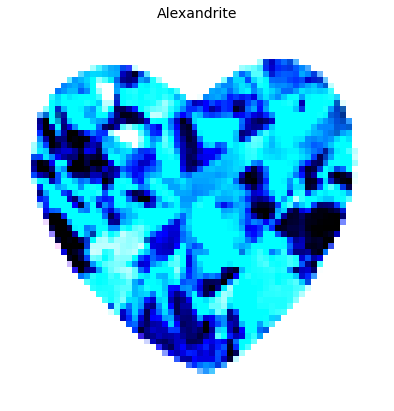

In [24]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [25]:
import os
NUM_Workers = os.cpu_count() # we will keep our number of weights as cpu_count
NUM_Workers

2

We will we downlaoding the weights from torchvision.models.EfficientNet_B0_Weights.
We will will transforming our data with these weights for better accuracy and lack of errors.

In [26]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [27]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [28]:
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_data_transform,
    test_data_transform, 
    batch_size: int, 
    num_workers: int):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
  train_class_names = train_data.classes

  test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_data_transform)
  
  test_class_names = test_data.classes

  print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
  # Turn train and test Datasets into DataLoaders
  train_dataloader = DataLoader(dataset=train_data, 
                                batch_size=32, # how many samples per batch?
                                num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                                shuffle=True) # shuffle the data?

  test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=32, 
                              num_workers=2, 
                              shuffle=False) # don't usually need to shuffle testing data

  return train_dataloader, test_dataloader, train_class_names, test_class_names

In [29]:
train_dataloader, test_dataloader, train_class_names, test_class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_data_transform = auto_transforms,
    test_data_transform = auto_transforms,
    batch_size=32,
    num_workers = NUM_Workers)

Train data:
Dataset ImageFolder
    Number of datapoints: 2856
    Root location: /content/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 363
    Root location: /content/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )


In [31]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [32]:
def display_random_images(dataset, classes = None, n = 10, display_shape = True, seed = 0):
  # Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
  
  # Set random seed
    if seed:
        random.seed(seed)

  # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
  
  # Setup plot
    plt.figure(figsize=(16, 8))

  # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


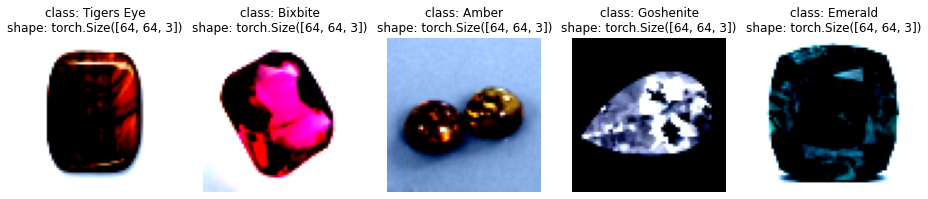

In [33]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=train_class_names,
                      seed=42)

### **3.Creating a model.**

The model we are using is [efficientnet_b0](https://arxiv.org/abs/1905.11946v5)

`EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient.` Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients. For example, if we want to use  times more computational resources, then we can simply increase the network depth by , width by , and image size by , where  are constant coefficients determined by a small grid search on the original small model. EfficientNet uses a compound coefficient  to uniformly scales network width, depth, and resolution in a principled way.

The compound scaling method is justified by the intuition that if the input image is bigger, then the network needs more layers to increase the receptive field and more channels to capture more fine-grained patterns on the bigger image.

The base EfficientNet-B0 network is based on the inverted bottleneck residual blocks of MobileNetV2, in addition to squeeze-and-excitation blocks.

EfficientNets also transfer well and achieve state-of-the-art accuracy on CIFAR-100 (91.7%), Flowers (98.8%), and 3 other transfer learning datasets, with an order of magnitude fewer parameters.

~ [Paper with code](https://paperswithcode.com/method/efficientnet#:~:text=EfficientNet%20is%20a%20convolutional%20neural,resolution%20using%20a%20compound%20coefficient.)

In [34]:
efficient_model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [35]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(efficient_model, input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) # do a test pass through of an example input size

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [36]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficient_model.features.parameters():
    param.requires_grad = False

In [37]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(train_class_names)

# Recreate the classifier layer and seed it to the target device
efficient_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [38]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(efficient_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 87]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [42]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.0001)

In [43]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [44]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [45]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, device = device):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader, 
                                        loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [46]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=efficient_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=80,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3333 | train_acc: 0.0677 | test_loss: 4.1820 | test_acc: 0.1612
Epoch: 2 | train_loss: 3.9942 | train_acc: 0.2538 | test_loss: 3.9121 | test_acc: 0.3246
Epoch: 3 | train_loss: 3.6963 | train_acc: 0.4101 | test_loss: 3.6623 | test_acc: 0.4205
Epoch: 4 | train_loss: 3.4233 | train_acc: 0.5076 | test_loss: 3.4439 | test_acc: 0.4830
Epoch: 5 | train_loss: 3.1806 | train_acc: 0.5687 | test_loss: 3.2431 | test_acc: 0.5220
Epoch: 6 | train_loss: 2.9653 | train_acc: 0.6052 | test_loss: 3.0530 | test_acc: 0.5585
Epoch: 7 | train_loss: 2.7632 | train_acc: 0.6392 | test_loss: 2.8821 | test_acc: 0.5533
Epoch: 8 | train_loss: 2.5910 | train_acc: 0.6677 | test_loss: 2.7749 | test_acc: 0.5741
Epoch: 9 | train_loss: 2.4393 | train_acc: 0.6833 | test_loss: 2.6360 | test_acc: 0.5741
Epoch: 10 | train_loss: 2.3062 | train_acc: 0.6986 | test_loss: 2.5350 | test_acc: 0.5845
Epoch: 11 | train_loss: 2.1704 | train_acc: 0.7184 | test_loss: 2.4267 | test_acc: 0.5871
Epoch: 12 | train_l

so after running for 1415.101 seconds the model gives up train accuracy of 95% and test accuracy of 70%.

This can be increased by fine tuning the model, adding data augumentation, increasing the learning rate and other ways.

### 4.**Verrfying the results.**

In [47]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

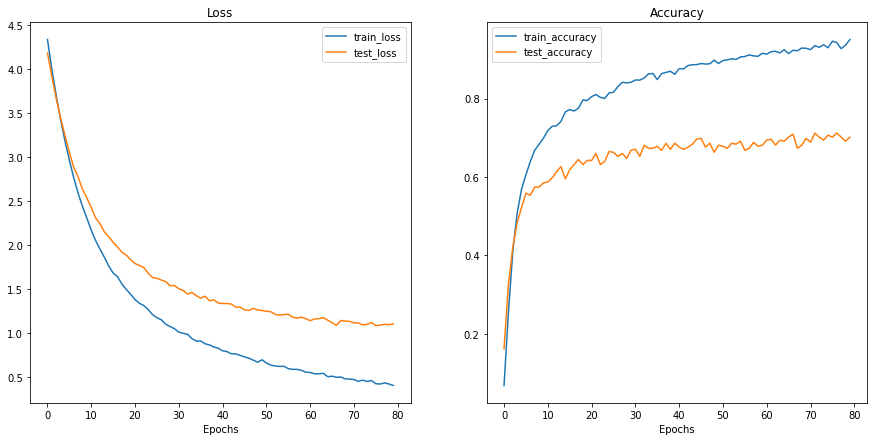

In [48]:
plot_loss_curves(results)

Those are some excellent looking loss curves!

It looks like the loss for both datasets (train and test) is heading in the right direction.

The same with the accuracy values, trending upwards.

Thus for now our model is working pretty well.

In [54]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f} | actual: {image_path.parent.stem}")
    plt.axis(False);

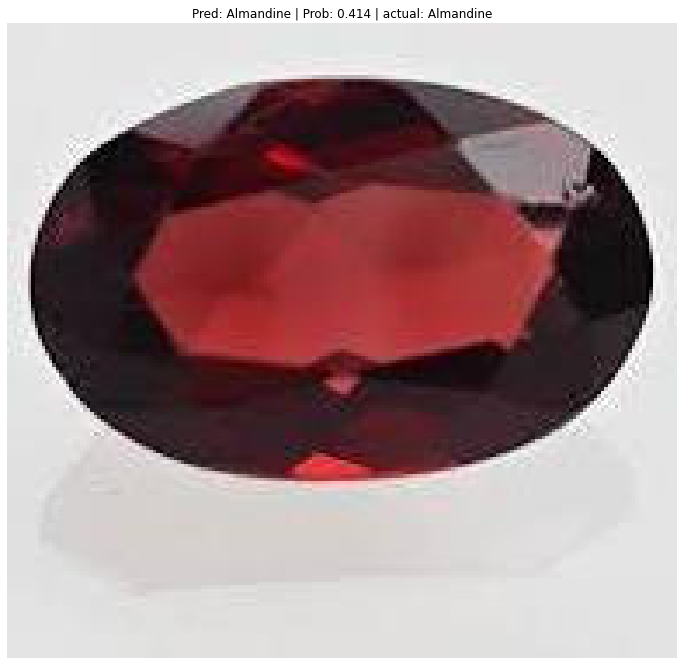

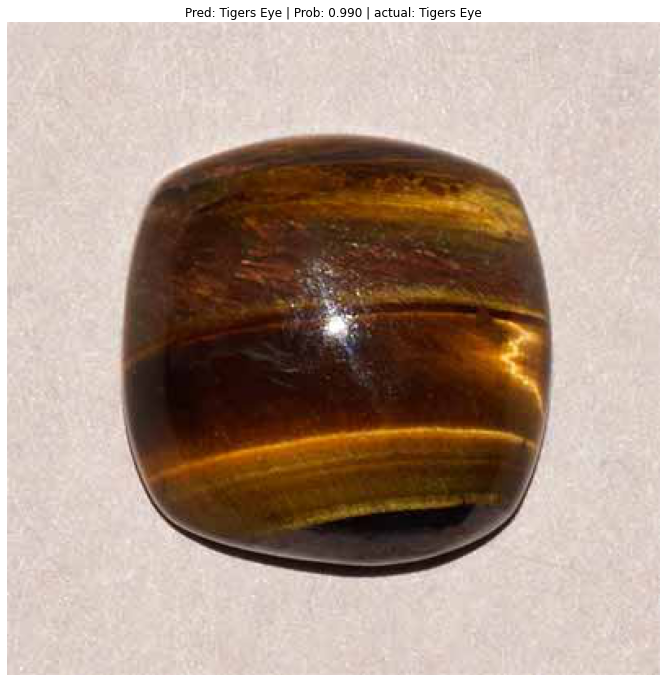

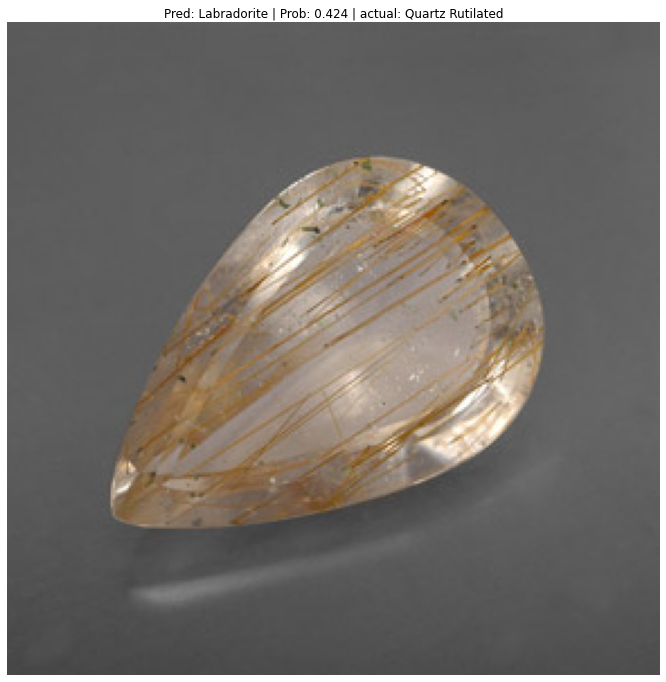

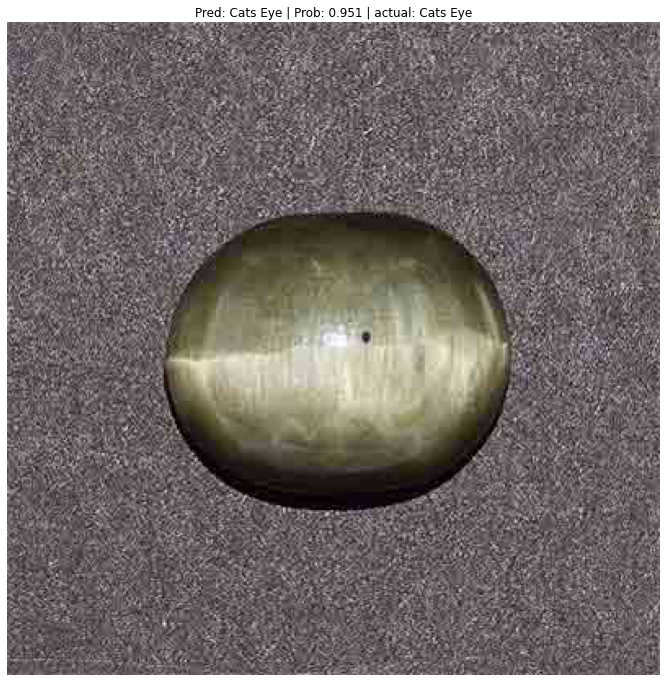

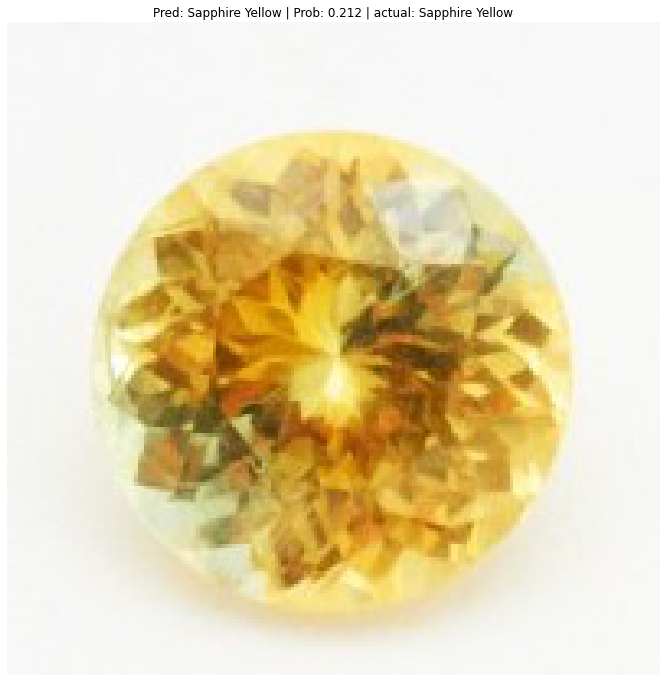

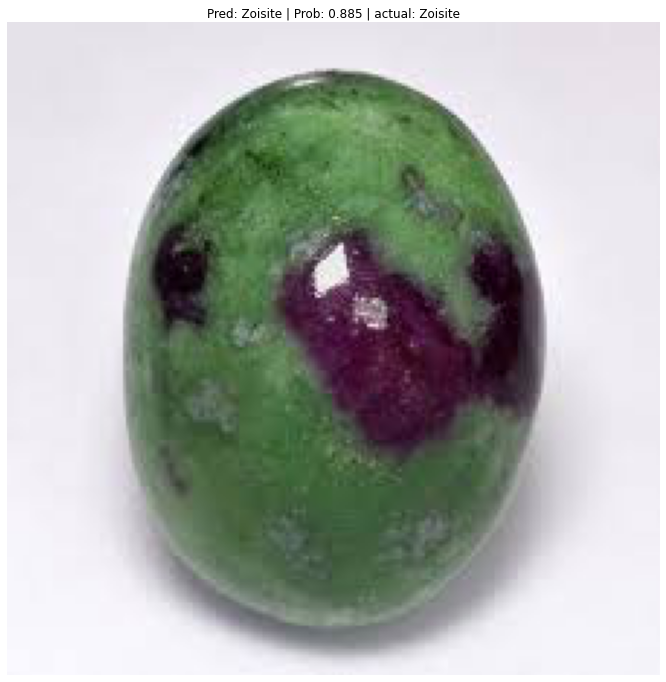

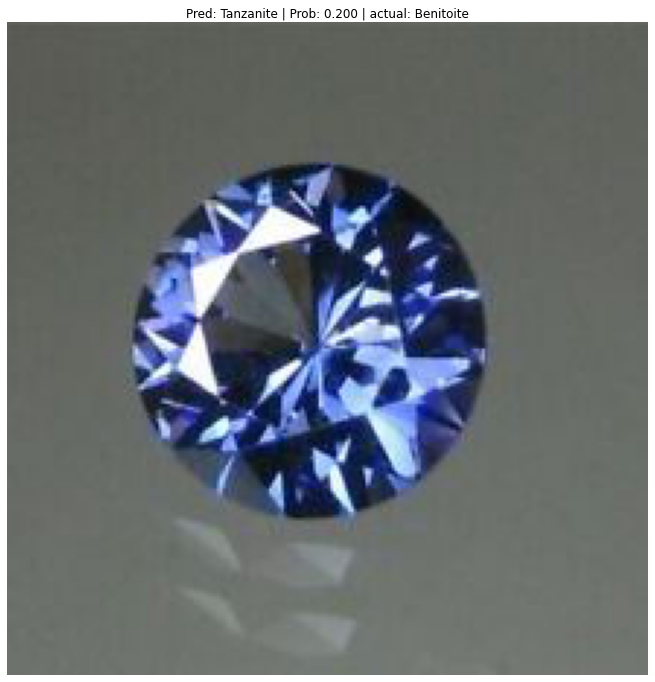

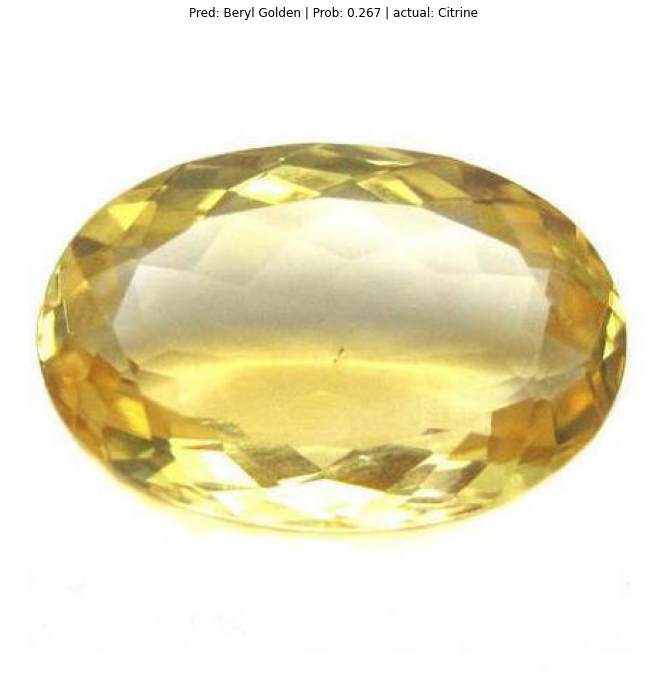

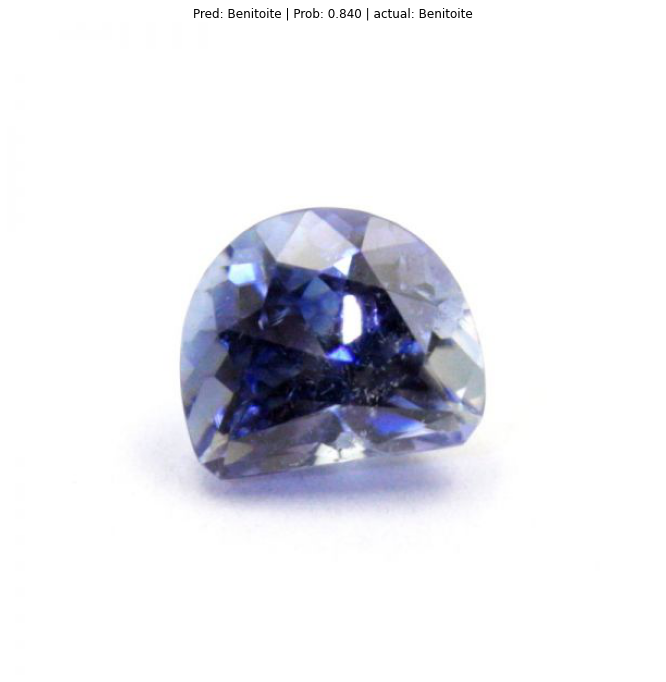

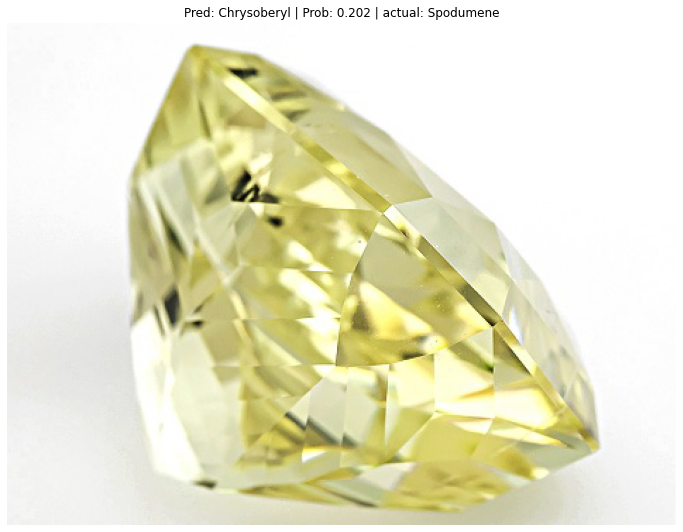

In [55]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 10
test_image_path_list = list(test_dir.glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=efficient_model, 
                        image_path=image_path,
                        class_names=test_class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 5.**Saving our Pytorch model.**

In [57]:
# 1. Create models directory 
MODEL_PATH = pathlib.Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "GemstoneClassificationModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=efficient_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/GemstoneClassificationModel.pth


Saving the model to google drive.

In [60]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [61]:
path = F"/content/gdrive/My Drive/{MODEL_NAME}" 
torch.save(obj=efficient_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=path)